# TELECOM CHURN MODELLING

made with regret while listening to [Symposium magaram](https://www.youtube.com/watch?v=Qt2pvlpGQL0&t=201s) on loop at 3am

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telecom-users-dataset/telecom_users.csv


In [2]:
data = pd.read_csv("../input/telecom-users-dataset/telecom_users.csv")
pd.options.display.max_columns = None

In [3]:
data.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [4]:
data.Churn.value_counts()

No     4399
Yes    1587
Name: Churn, dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5986 non-null   int64  
 1   customerID        5986 non-null   object 
 2   gender            5986 non-null   object 
 3   SeniorCitizen     5986 non-null   int64  
 4   Partner           5986 non-null   object 
 5   Dependents        5986 non-null   object 
 6   tenure            5986 non-null   int64  
 7   PhoneService      5986 non-null   object 
 8   MultipleLines     5986 non-null   object 
 9   InternetService   5986 non-null   object 
 10  OnlineSecurity    5986 non-null   object 
 11  OnlineBackup      5986 non-null   object 
 12  DeviceProtection  5986 non-null   object 
 13  TechSupport       5986 non-null   object 
 14  StreamingTV       5986 non-null   object 
 15  StreamingMovies   5986 non-null   object 
 16  Contract          5986 non-null   object 


In [6]:
[col for col in data.columns if " " in data[col].value_counts().index.tolist()]

['TotalCharges']

In [7]:
data["TotalCharges"].replace(to_replace = " ", value = np.nan, inplace = True)
data.dropna(inplace = True)

In [8]:
import plotly.express as px
import plotly.graph_objects as go

## Exploratory Data Analysis

i bet the distribution is BAD!

In [9]:
px.pie(values = data.Churn.value_counts().values.tolist(), names = data.Churn.value_counts().index.tolist(),title = "Y variable distribution")

we might have to resample this later.

lets start with basic analysis and work our way through complex conditions

In [10]:
px.pie(values = data["gender"].value_counts().values.tolist(), names = data["gender"].value_counts().index.tolist(), title = "gender distribution is Telecom")

In [11]:
fig = go.Figure(
    [go.Bar(name = "senior_citizen - 1", x = data[data["SeniorCitizen"] == 1].gender.value_counts().index.tolist(),
            y = data[data["SeniorCitizen"] == 1].gender.value_counts().values.tolist()),
     go.Bar(name = "senior_citizen - 0", x = data[data["SeniorCitizen"] == 0].gender.value_counts().index.tolist(),
            y = data[data["SeniorCitizen"] == 0].gender.value_counts().values.tolist())]
)
fig.update_layout(barmode = "group",title = "gender distribution based on senior citizenship")

In [12]:
px.violin(data["tenure"],box = True, points = "all")

lets see what kind of internet service senior citizens have

In [13]:
sen = data[data["SeniorCitizen"] == 1]
no_sen = data[data["SeniorCitizen"] == 0]

In [14]:
fig = go.Figure(
    [go.Bar(x = sen.InternetService.value_counts().index.tolist(), y = sen.InternetService.value_counts().values.tolist(), name = "senior_citizens"),
    go.Bar(x = no_sen.InternetService.value_counts().index.tolist(), y = no_sen.InternetService.value_counts().values.tolist(), name = "non-senior_citizens")]
)
fig.update_layout(barmode = "group", title = "internet service differences between senior citizens and young citizens")

pretty updated oof!

### A guide to senior citizen telecom preferences

do senior citizens opt for onlinebackup?

In [15]:
dims1 = ['PhoneService', 'MultipleLines', 'OnlineSecurity',"OnlineBackup"]
fig = px.parallel_categories(sen, dimensions = dims1,
                color="MonthlyCharges", color_continuous_scale=px.colors.sequential.Inferno,
                labels ={k:k for k in dims1})
fig.update_layout(title = "comprehensive correlation for senior citizens #1")

In [16]:
dims2 = ["DeviceProtection","TechSupport", "StreamingTV","StreamingMovies"]
fig = px.parallel_categories(sen, dimensions = dims2,
                color="MonthlyCharges", color_continuous_scale=px.colors.sequential.Plotly3,
                labels ={k:k for k in dims2})
fig.update_layout(title = "comprehensive correlation for senior citizens #2")

### non-senior citizens guide to many variables

In [17]:
dims1 = ['PhoneService', 'MultipleLines', 'OnlineSecurity',"OnlineBackup"]
fig = px.parallel_categories(no_sen, dimensions = dims1,
                color="MonthlyCharges", color_continuous_scale=px.colors.sequential.Inferno,
                labels ={k:k for k in dims1})
fig.update_layout(title = "comprehensive correlation for non-senior citizens #1")

In [18]:
dims2 = ["DeviceProtection","TechSupport", "StreamingTV","StreamingMovies"]
fig = px.parallel_categories(no_sen, dimensions = dims2,
                color="MonthlyCharges", color_continuous_scale=px.colors.sequential.Plotly3,
                labels ={k:k for k in dims2})
fig.update_layout(title = "comprehensive correlation for non-senior citizens #2")

### back to main data, lets stop being indifferent towards aged people

In [19]:
px.bar_polar(data, r = data.PaymentMethod.value_counts().values.tolist(), theta = data.PaymentMethod.value_counts().index.tolist(),
                   color = data.PaymentMethod.value_counts().index.tolist(),
                   title = "payment method!")

mailed check in 2021? damn

i am a bit curious about something

In [20]:
from plotly.subplots import make_subplots

In [21]:
fig = make_subplots(rows = 1, cols = 2,
                      subplot_titles = ("happily ever after?(senior)","forever single?(non_senior)"),
                    specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(values = sen["Partner"].value_counts().values.tolist(), labels = sen["Partner"].value_counts().index.tolist(),hole = 0.4),1,1)
fig.add_trace(go.Pie(values = no_sen["Partner"].value_counts().values.tolist(), labels = no_sen["Partner"].value_counts().index.tolist(),hole = 0.4),1,2)
fig.show()

thats pretty inconclusive...i am a bit disappointed

In [22]:
px.bar(x = data.Contract.value_counts().index.tolist(), y = data.Contract.value_counts().values.tolist(),
       title = "popularity of telecomm subcription duration", color = data.Contract.value_counts().index.tolist())

In [23]:
px.violin(data["MonthlyCharges"],box = True , points = "all",title = "monthly charges distribution")

In [24]:
px.violin(data["TotalCharges"],box = True , points = "all",title = "total charges distribution")

## data preprocessing and preparation

In [25]:
data_copy = data.copy(deep = True)

In [26]:
for col in data_copy.columns[2:]:
    print(f"{col}: \n{data_copy[col].value_counts()}\n\n")

gender: 
Male      3044
Female    2932
Name: gender, dtype: int64


SeniorCitizen: 
0    5010
1     966
Name: SeniorCitizen, dtype: int64


Partner: 
No     3080
Yes    2896
Name: Partner, dtype: int64


Dependents: 
No     4195
Yes    1781
Name: Dependents, dtype: int64


tenure: 
1     510
72    308
2     194
3     169
4     154
     ... 
38     49
44     47
45     47
39     44
36     43
Name: tenure, Length: 72, dtype: int64


PhoneService: 
Yes    5388
No      588
Name: PhoneService, dtype: int64


MultipleLines: 
No                  2843
Yes                 2545
No phone service     588
Name: MultipleLines, dtype: int64


InternetService: 
Fiber optic    2627
DSL            2064
No             1285
Name: InternetService, dtype: int64


OnlineSecurity: 
No                     2982
Yes                    1709
No internet service    1285
Name: OnlineSecurity, dtype: int64


OnlineBackup: 
No                     2604
Yes                    2087
No internet service    1285
Name: Online

To avoid redundant levels in a categorical variable and to deal with rare levels, we can simply combine the different levels.

In [27]:
data_copy["OnlineSecurity"].replace(to_replace = ["No internet service"], value = ["No"], inplace = True)
data_copy["OnlineBackup"].replace(to_replace = ["No internet service"], value = ["No"], inplace = True)
data_copy["DeviceProtection"].replace(to_replace = ["No internet service"], value = ["No"], inplace = True)
data_copy["TechSupport"].replace(to_replace = ["No internet service"], value = ["No"], inplace = True)
data_copy["StreamingTV"].replace(to_replace = ["No internet service"], value = ["No"], inplace = True)
data_copy["StreamingMovies"].replace(to_replace = ["No internet service"], value = ["No"], inplace = True)
data_copy["MultipleLines"].replace(to_replace = ["No phone service"], value = ["No"], inplace = True)

label encoding 2 value categorical variables

In [28]:
label_list = [col for col in data_copy.columns[2:-1] if len(data_copy[col].value_counts().index) == 2]
for col in label_list:
    data_copy[col].replace(to_replace = data_copy[col].value_counts().index.tolist(), value = [*range(0,len(data_copy[col].value_counts().index.tolist()))], inplace = True)

now, we are left with..

- 'tenure',             --- cardinal 
- 'InternetService',    --- categorical
- 'Contract',           --- categorical
- 'PaymentMethod',      --- categorical
- 'MonthlyCharges',     --- decimals
- 'TotalCharges'        --- decimals(IS actually str in dataset)

so total_charges is in str..cool, now back to FLOAT

we leave out the numeric values and only convert categorical

In [29]:
data_copy["TotalCharges"] = data_copy["TotalCharges"].astype(np.float32)

In [30]:
one_hot_list = [data_copy.columns.tolist().index(col) for col in data_copy.columns[2:-1] if len(data_copy[col].value_counts().index) > 2 and type(data_copy[col][0]) == str]

In [31]:
one_hot_list

[9, 16, 18]

In [32]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
columnTransformer = ColumnTransformer([('encoder',
                                        OneHotEncoder(),
                                        one_hot_list)],
                                      remainder='passthrough')
data_copy = pd.DataFrame(np.array(columnTransformer.fit_transform(data_copy)))

11 is that pesky costumerID column i forgot to drop at start and too lazy to fix it at start, so imma fix it HERE!

In [33]:
data_copy.drop([11], axis = 1,inplace = True)

In [34]:
data_copy[28].replace(to_replace = ["Yes","No"], value = [1,0], inplace = True)

In [35]:
data_copy.head()

,0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,0,0,1,0,0,1,0,1,0,0,1869,0,0,1,1,72,0,1,0,0,0,0,0,0,1,24.1,1734.65,0
1,0,1,0,1,0,0,0,1,0,0,4528,1,0,0,0,44,0,0,0,1,1,0,1,0,0,88.15,3973.2,0
2,0,1,0,1,0,0,1,0,0,0,6344,1,1,1,0,38,0,1,0,0,0,0,0,0,0,74.95,2869.85,1
3,1,0,0,1,0,0,0,0,1,0,6739,0,0,0,0,4,0,0,0,0,0,0,0,1,0,55.9,238.5,0
4,1,0,0,1,0,0,0,0,1,0,432,0,0,0,0,2,0,0,1,0,1,0,0,0,1,53.45,119.5,0


In [36]:
from sklearn.model_selection import train_test_split

x = data_copy.iloc[:,:-1].values
y = data_copy.iloc[:,-1].values

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 177013)

### applying [SMOTEENN](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/) algorithm to oversample and undersample to move closer to balanced distribution

In [37]:
from imblearn.combine import SMOTEENN
from collections import Counter

In [38]:
print("Before :",Counter(y_train), len(x_train),len(y_train),"\n")
smoteenn = SMOTEENN()
x_train_re,y_train_re = smoteenn.fit_resample(x_train,y_train)

print("After :",Counter(y_train_re), len(x_train_re),len(y_train_re))

Before : Counter({0: 3519, 1: 1261}) 4780 4780 

After : Counter({1: 1890, 0: 1439}) 3329 3329


## machine learning/neural networks with metrics included :)

so, first we will explore machine learning and then we will create ANN

1. logistic regression

2. Decision tree Classifier

3. random forest classifier

4. support vector with RBF kernel

5. XGboost(the Competitive algorithm)

In [39]:
from sklearn.metrics import classification_report,roc_auc_score,roc_curve
import matplotlib.pyplot as plt

In [40]:
# great helper function
def eval(algo):
    algo.fit(x_train_re,y_train_re)
    y_pred = algo.predict(x_test)
    print(classification_report(y_test,y_pred))
    y_pred_proba = algo.predict_proba(x_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr ,label = f"auc={str(auc)}")
    plt.legend(loc=4)
    plt.title(f"ROC Curve of {algo}")
    plt.show()

### logistic regression

              precision    recall  f1-score   support

           0       0.91      0.70      0.79       870
           1       0.51      0.81      0.62       326

    accuracy                           0.73      1196
   macro avg       0.71      0.76      0.71      1196
weighted avg       0.80      0.73      0.75      1196



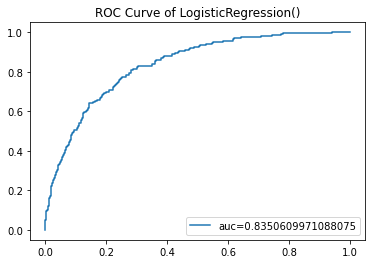

In [41]:
from sklearn.linear_model import LogisticRegression
eval(algo = LogisticRegression())

Support vector classifier

              precision    recall  f1-score   support

           0       0.81      0.59      0.68       870
           1       0.36      0.63      0.46       326

    accuracy                           0.60      1196
   macro avg       0.59      0.61      0.57      1196
weighted avg       0.69      0.60      0.62      1196



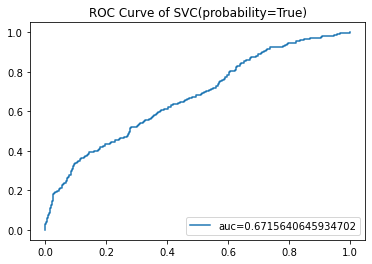

In [42]:
from sklearn.svm import SVC
eval(algo = SVC(probability = True))

### Decision Tree classifier

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       870
           1       0.49      0.55      0.52       326

    accuracy                           0.72      1196
   macro avg       0.66      0.67      0.66      1196
weighted avg       0.73      0.72      0.73      1196



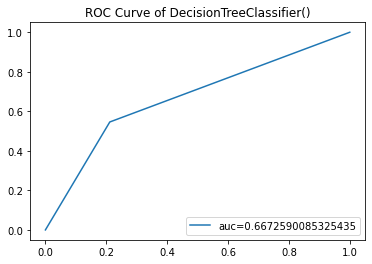

In [43]:
from sklearn.tree import DecisionTreeClassifier
eval(algo = DecisionTreeClassifier())

### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       870
           1       0.61      0.57      0.59       326

    accuracy                           0.78      1196
   macro avg       0.73      0.72      0.72      1196
weighted avg       0.78      0.78      0.78      1196



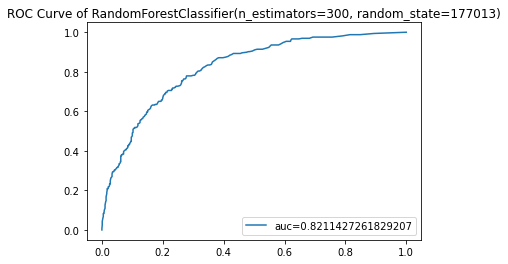

In [44]:
from sklearn.ensemble import RandomForestClassifier
eval(algo = RandomForestClassifier(n_estimators = 300, random_state = 177013))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       870
           1       0.61      0.59      0.60       326

    accuracy                           0.79      1196
   macro avg       0.73      0.72      0.73      1196
weighted avg       0.78      0.79      0.78      1196



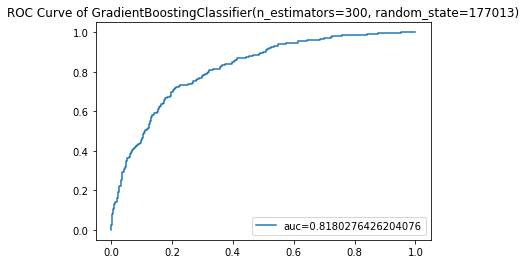

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
eval(algo = GradientBoostingClassifier(n_estimators = 300, random_state = 177013))

### neural network using tensorflow

In [46]:
import tensorflow
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [47]:
N,D = x_train.shape

In [48]:
i = Input(shape = (D,))
x = Dense(16,activation = "relu")(i)
x = Dense(8,activation = "relu")(x)
x = Dense(1,activation = "sigmoid")(x)

model = Model(i,x, name = "churn_banger_9000")

model.compile(loss = "binary_crossentropy", metrics = ["accuracy"], optimizer = Adam(lr = 0.0001))

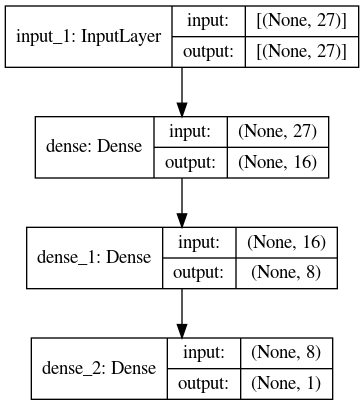

In [49]:
tensorflow.keras.utils.plot_model(model,show_shapes = True)

In [50]:
x_train_arr = np.asarray(x_train_re).astype(np.float32)
y_train_arr = np.asarray(y_train_re).astype(np.float32)

In [51]:
x_test_arr = np.asarray(x_test).astype(np.float32)
y_test_arr = np.asarray(y_test).astype(np.float32)

In [52]:
his = model.fit(x_train_arr,y_train_arr, epochs = 75, validation_data = (x_test_arr,y_test_arr))

Epoch 1/75
105/105 [==============================] - 2s 9ms/step - loss: 676.7774 - accuracy: 0.4323 - val_loss: 339.9246 - val_accuracy: 0.7274
Epoch 2/75
105/105 [==============================] - 0s 4ms/step - loss: 445.7854 - accuracy: 0.4478 - val_loss: 228.2255 - val_accuracy: 0.7274
Epoch 3/75
105/105 [==============================] - 0s 4ms/step - loss: 279.6901 - accuracy: 0.4653 - val_loss: 166.0521 - val_accuracy: 0.6982
Epoch 4/75
105/105 [==============================] - 0s 3ms/step - loss: 176.7638 - accuracy: 0.6647 - val_loss: 146.2019 - val_accuracy: 0.6597
Epoch 5/75
105/105 [==============================] - 0s 3ms/step - loss: 156.7760 - accuracy: 0.6709 - val_loss: 131.4394 - val_accuracy: 0.6329
Epoch 6/75
105/105 [==============================] - 0s 3ms/step - loss: 140.9148 - accuracy: 0.6845 - val_loss: 117.4771 - val_accuracy: 0.6179
Epoch 7/75
105/105 [==============================] - 0s 3ms/step - loss: 118.3730 - accuracy: 0.6949 - val_loss: 103.5639 -

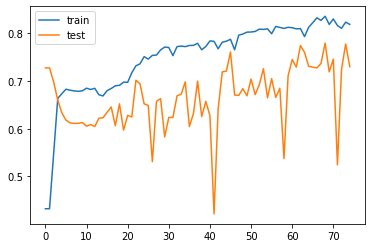

In [53]:
plt.plot(his.history["accuracy"], label = "train")
plt.plot(his.history["val_accuracy"], label = "test")
plt.legend()

In [54]:
y_pred_nn = model.predict(x_test_arr)
y_pred_ceil = [1 if y_pred > 0.5 else 0 for y_pred in y_pred_nn]

In [55]:
print(classification_report(y_test,y_pred_ceil))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80       870
           1       0.50      0.70      0.59       326

    accuracy                           0.73      1196
   macro avg       0.69      0.72      0.69      1196
weighted avg       0.77      0.73      0.74      1196



maybe there is room for improvement

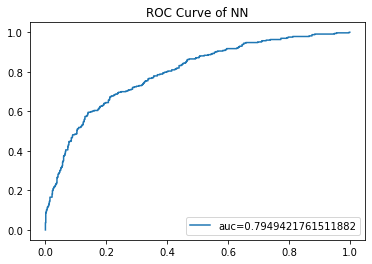

In [56]:
fpr, tpr, _ = roc_curve(y_test,y_pred_nn)
auc = roc_auc_score(y_test, y_pred_nn)
plt.plot(fpr, tpr ,label = f"auc={str(auc)}")
plt.legend(loc=4)
plt.title(f"ROC Curve of NN")
plt.show()

## conclusion

1. logistic regression -- 73%

2. Decision tree Classifier -- 72%                               

3. random forest classifier -- 78% | Winner! 

4. support vector classifier -- 61%                        

5. XGboost(the Competitive algorithm) -- 78% | Winner! 

6. Neural Network(can be improved further) -- 70% |consolation 